In [1]:
from __future__ import division

import BeautifulSoup
import numpy as np
import pandas as pd

import glob
import os.path

In [2]:
def explode(x, level):
    exp = 1/level
    if x<0:
        return -((-x)**exp)
    else:
        return x**exp

In [3]:
def summaryVector(data, size):
    nl,ca = data['NL'].sum()/size, data['CA'].sum()/size
    return nl, ca

def getSummaryData(data):
    data['NL'] = data['Total-NL'].apply(lambda x: explode(x, 5))
    data['CA'] = data['Total-CA'].apply(lambda x: explode(x, 5))

    dataSize = len(data)

    summary = []
    summary.append(summaryVector(data, dataSize)) # 0
    summary.append(summaryVector(data[(data['NL']>0) & (data['CA']>0)], dataSize)) # 1
    summary.append(summaryVector(data[(data['NL']>0) & (data['CA']<0)], dataSize)) # 2
    summary.append(summaryVector(data[(data['NL']<0) & (data['CA']>0)], dataSize)) # 3
    summary.append(summaryVector(data[(data['NL']<0) & (data['CA']<0)], dataSize)) # 4
    summary.append((data['NL'],data['CA'],data['Word'])) #5
    
    return summary

In [4]:
# pklFiles = glob.glob('../data/corpus.karina.nerINL.2012-10-26/*.pkl')
# pklFiles = glob.glob('../data/corpus.sanders.nerINL.2012-10-24/*.pkl')

# pklFiles = glob.glob('../data/corpus.karina.nerINL.2012-10-26/pkls_v1/*.pkl')
pklFiles = glob.glob('../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/*.pkl')


xmlFiles = [ pklFile.replace('.pkl', '.xml') for pklFile in pklFiles ]
xmlFiles = [ xmlFile.replace('pkls_v1/', '') for xmlFile in xmlFiles ]

In [5]:
len(pklFiles)

37

In [6]:
def getNymData(nym_xml):
    '''
    Returns:
      freq    The frequency of term on any form it was observed
      normalizedForms    A list of normalized ways in which the text has been observed
    '''
    freqs = [ usg.text for usg in nym_xml.findAll('usg') if ('type', 'frequency') in usg.attrs ]
    freq = np.array([ int(f) for f in freqs]).max()
    nstype = nym_xml.get('ns:type')
    
    normalizedForms = [ orth.text for orth in nym_xml.findAll('orth') if ('type', 'normalized') in orth.attrs ]
    
    return freq, normalizedForms,nstype


In [7]:
allSummaries = {}
for xml, pkl in zip(xmlFiles, pklFiles):
    if os.path.isfile(pkl):
        print 'Loading data from ',pkl,'...'

        # Read title from XML
        tei = open(xml).read()
        teiSoup = BeautifulSoup.BeautifulSoup(tei)
        docTitle = teiSoup.findAll('title')[0].getText()
        print '  > ',docTitle
        
        # Read data from PKL
        data = pd.read_pickle(pkl)
        
        allSummaries[docTitle] = getSummaryData(data)
    else:
        print 'Skipping ',xml,'...'


Loading data from  ../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/nl.ns.d.9053333029.s.pkl ...
  >  Offerande
Loading data from  ../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/nl.ns.d.9057134829.s.pkl ...
  >  Voordewind
Loading data from  ../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/nl.ns.d.9022914186.s.pkl ...
  >  De schaduw en de maagd
Loading data from  ../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/nl.ns.d.902230292X.s.pkl ...
  >  Een dag als een ander
Loading data from  ../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/nl.ns.d.9029098961.s.pkl ...
  >  Dierbaar venijn: roman
Loading data from  ../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/nl.ns.d.9044604279.s.pkl ...
  >  Blauw bloed
Loading data from  ../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/nl.ns.d.9023404319.s.pkl ...
  >  De slakken van Canêt d'Olt: roman
Loading data from  ../data/corpus.sanders.nerINL.2012-10-24/pkls_v1/nl.ns.d.9025426158.s.pkl ...
  >  De insluiper
Loading data from  ../data/corpus.sa

In [8]:
import matplotlib.pylab as plt
from matplotlib.mlab import dist
import numpy as np
from IPython.display import Image
from IPython.display import display

In [9]:
def plotOne(bookTitle, data):
    nl_tot,ca_tot = data[0]
    
    nl,ca = [],[]
    for i in range(1,5):
        nl.append(data[i][0])
        ca.append(data[i][1])

    plt.plot([-1, 1], [0, 0] , 'r-')
    plt.plot([0, 0] , [-1, 1],'r-')

    plt.plot([0, nl_tot], [0, ca_tot], 'g-o')
    plt.plot([0, nl[0]], [0, ca[0]], 'm-o')
    plt.plot([0, nl[1]], [0, ca[1]], 'm-o')
    plt.plot([0, nl[2]], [0, ca[2]], 'm-o')
    plt.plot([0, nl[3]], [0, ca[3]], 'm-o')

    plt.xlabel('NL')
    plt.ylabel('CA')

    plt.title(bookTitle)
    plt.axis('equal')

In [10]:
def plotCloud(bookTitle, data):
    plotOne(bookTitle, data)
    points_nl,points_ca,points_lbl = data[5]
    
    plt.plot(points_nl,points_ca, 'b+')
    
    points = []
    for nl,ca,txt in zip(points_nl,points_ca,points_lbl):
        point = np.array([nl, ca])
        distances = [ dist(point, x) for x in points ]
        if len(distances)==0 or np.min(distances)>0.1:
            plt.annotate(txt, (nl,ca), rotation=-10)
            points.append(point)
    
    plt.axis([-1,1,-1,1])

In [11]:
def plotAll(allSummaries):
#    plt.plot([-1, 1], [0, 0] , 'r-')
#    plt.plot([0, 0] , [-1, 1],'r-')
    plt.plot(0, 0,'r+')
    
    for bookTitle in allSummaries:
        data = allSummaries[bookTitle]
        nl_tot,ca_tot = data[0]
        plt.plot(nl_tot, ca_tot, 'go')
        plt.annotate(bookTitle, (nl_tot,ca_tot), rotation=-10)

    plt.title('All books')
    plt.xlabel('NL')
    plt.ylabel('CA')
    plt.axis('equal')

In [11]:
for bookTitle in allSummaries:
    plt.figure(figsize=(4,4))
    plotCloud(bookTitle, allSummaries[bookTitle])
    plt.savefig('images/' + bookTitle + '_cloud.png')
    plt.close()
#    display(Image(filename='images/' + bookTitle + '_cloud.png'))


In [12]:
for bookTitle in allSummaries:
    plt.figure(figsize=(4,4))
    plotOne(bookTitle, allSummaries[bookTitle])
    plt.savefig('images/' + bookTitle + '.png')
    plt.close()
#    display(Image(filename='images/' + bookTitle + '.png'))

In [13]:
plt.figure(figsize=(4,4))
plotAll(allSummaries)
plt.savefig('images/all_books.png')
plt.close()
#display(Image(filename='images/all_books.png'))


In [14]:
for bookTitle in allSummaries:
    data = allSummaries[bookTitle]
    nl_tot,ca_tot = data[0]
    print '%s,%.6f,%.6f'%(bookTitle,nl_tot,ca_tot)


Rendez-vous,0.145970,0.177727
Motormoeder,-0.018776,0.017334
Blauw bloed,-0.008480,-0.061937
De eetclub,0.059043,-0.020585
Mieke Maaike's obscene jeugd: een pornografisch verhaal, voorafgegaan door een proefschrift 'in en om het kutodelisch verschijnsel', waarmee student Steivekleut promoveerde,0.170668,0.092228
Hoffman's honger: roman,0.012165,0.000758
Offerande,0.132201,-0.025728
De hartjacht: roman,-0.048481,-0.066477
De schaduw en de maagd,-0.188576,-0.002418
Je bent maar een mens: een leven tussen twee tijden,0.267981,-0.051087
Het smarán, het vikka, de ronko en al de andere kleuren van de geschiedenis: roman,-0.034218,-0.009550
Een gelijkend portret,0.031701,0.017503
Het huis tussen de heuvels,-0.168507,-0.014500
De Feniks: een familiekroniek,0.158932,0.003553
Een beeldje voor Venus en Reis in het atoomtijdperk: twee reisnovellen,-0.193089,-0.110722
De zeemeermin: roman,0.079046,-0.017786
Drie rode rozen: een novelle,0.067773,0.076582
De slakken van Canêt d'Olt: roman,0.097270,0.

In [20]:
xml = xmlFiles[0]
pkl = pklFiles[0]


tei = open(xml).read()
teiSoup = BeautifulSoup.BeautifulSoup(tei)
docTitle = teiSoup.findAll('title')[0].getText()

nymList = teiSoup.findAll('nym')
nymData = [getNymData(nym) for nym in nymList]

data = pd.read_pickle(pkl)

data['Type'] = ''

In [56]:
i = 0
for word in data['Word']:
    freq,origWords,nstype = nymData[i]
    origWord = origWords[0]
    row = data[data['Word']==word]
    print '"%s",%.6f,%.6f,"%s",%s'%(word,row['Total-NL'].mean(),row['Total-CA'].mean(),origWord,nstype)
    i += 1

for i in range(i,len(nymData)):
    freq,origWords,nstype = nymData[i]
    origWord = origWords[0]
    print ',,,"%s",%s'%(origWord,nstype)


"Amor fati",0.041540,-0.026924,"AMOR  FATI",person
"Menahem",-0.128485,-0.128485,"MENACHEM",person
"Jakob",-0.217372,-0.105555,"JACOB",person
"Pauline",2.190019,1.320824,"PAULA",person
"Herod",-0.145795,-0.003695,"ZEICSCHECK",person
"Jochebed",-0.189785,-0.033583,"HERODES",person
"Aron",-0.086849,-0.009340,"RIMPEL",person
"Marie",0.057278,0.096713,"MIESJE",person
"Simson",0.101412,-0.107428,"JOCHEBED",person
"Mussolini (disambiguation)",0.063141,0.048108,"OERIE",person
"Ararat",-0.059701,-0.003485,"ARON",person
"Abel (disambiguation)",-0.167366,-0.034060,"ELIE",person
"God (disambiguation)",4.581480,-4.634376,"FRITS",person
"Ursula",0.077940,0.003990,"MARIE",person
"Christus",0.000000,0.000000,"JITZCHAK",person
"Clara (disambiguation)",-1.546105,-0.039180,"SIMSON",person
"Mies",-0.050226,-0.050226,"MUSSOLINI",person
"Fritz",0.083580,-0.030768,"SUHIET",person
"Abel Herzberg",0.113935,0.063106,"ARARAT",person
"Simon",0.139116,0.060215,"DRIES",person
"David (disambiguation)",-0.956035,0.1

In [43]:
allDataList = []

for xml, pkl in zip(xmlFiles, pklFiles):
    if os.path.isfile(pkl):        
        # Read data from PKL
        data = pd.read_pickle(pkl)
        allDataList.append(data)

allData = pd.concat(allDataList, join='outer')

In [54]:
with open('results.csv') as fout:
    for word in allData['Word']:
        allData['Word']
        row = allData[allData['Word']==word]
        print '"%s",%.6f,%.6f'%(word,row['Total-NL'].mean(),row['Total-CA'].mean())

0.02070093317181227

In [63]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [107]:
def candlePerBook(bookTitle, summaryData):
    data_nl, data_ca, data_names = summaryData[5]

    plt.boxplot(data_nl, showfliers=False)

    points = []
    for nl,txt in zip(data_nl,data_names):
        point = np.array([1.2,nl])
        distances = [ dist(point, x) for x in points ]
        if len(distances)==0 or np.min(distances)>0.05:
            plt.annotate(txt, point)
            points.append(point)

    plt.title(bookTitle)
    plt.axis([0,2,-1,1]);

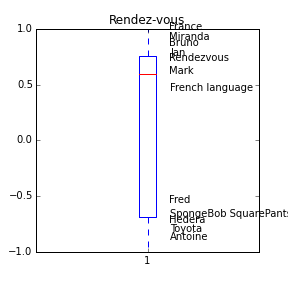

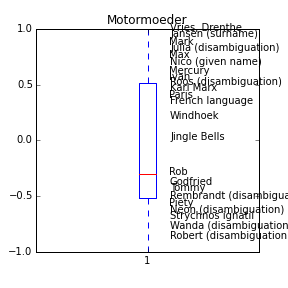

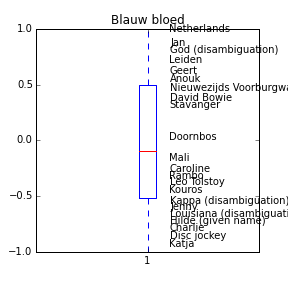

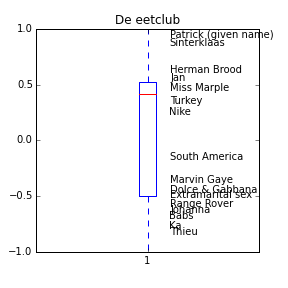

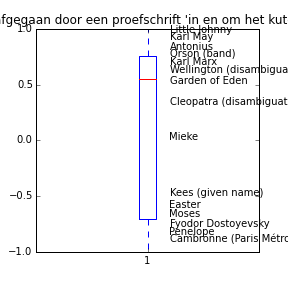

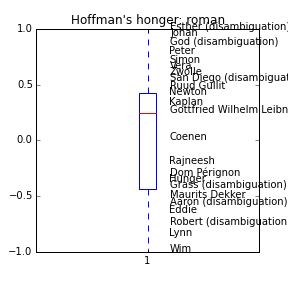

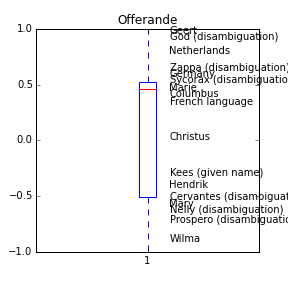

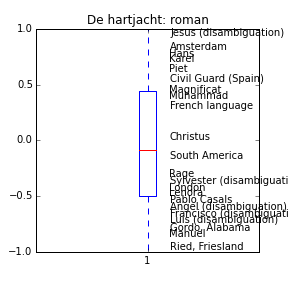

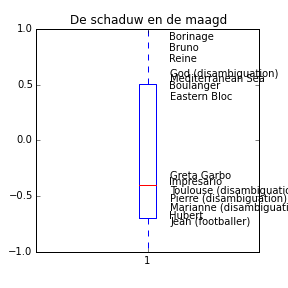

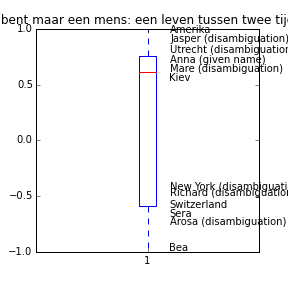

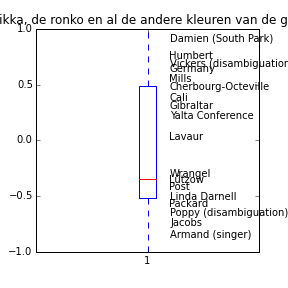

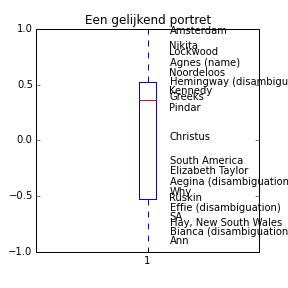

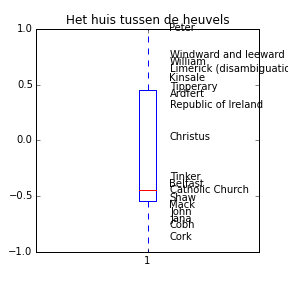

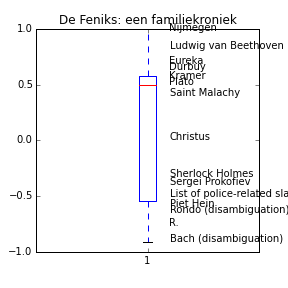

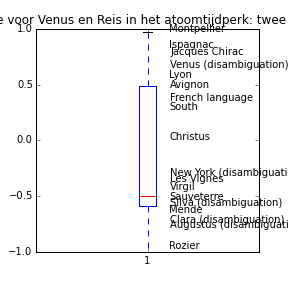

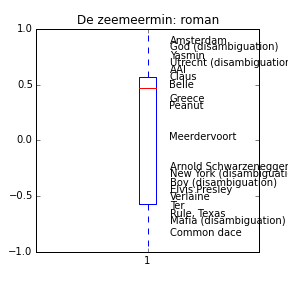

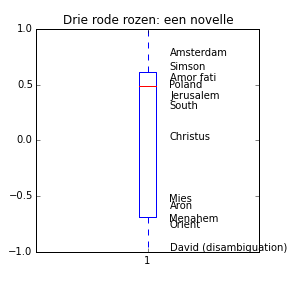

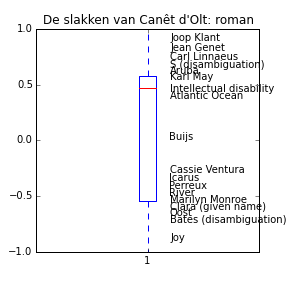

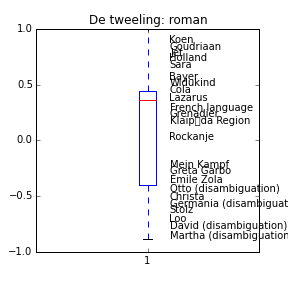

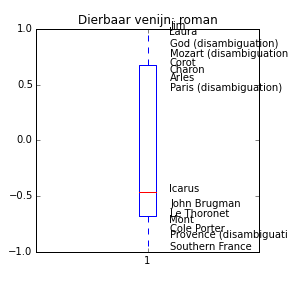

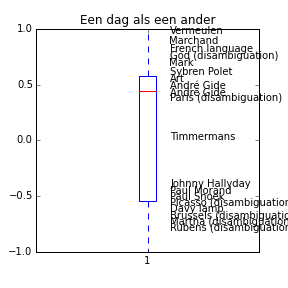

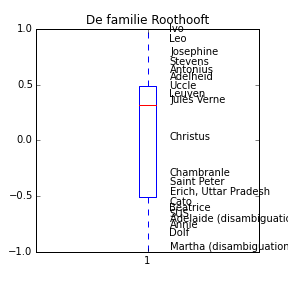

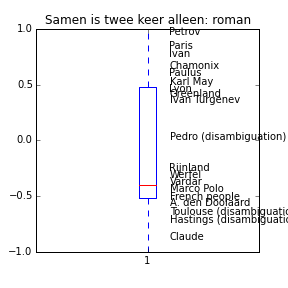

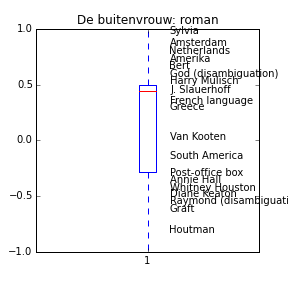

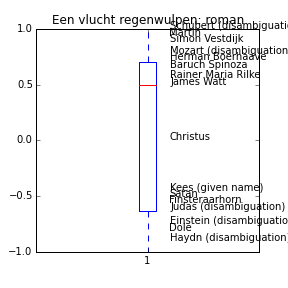

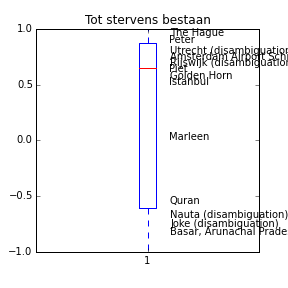

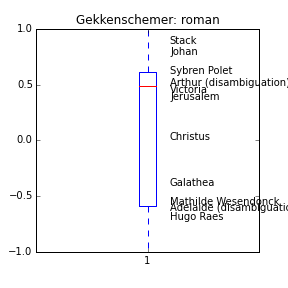

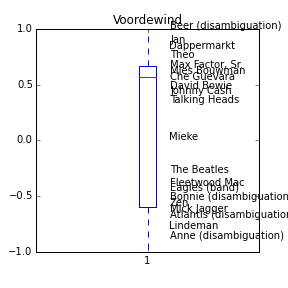

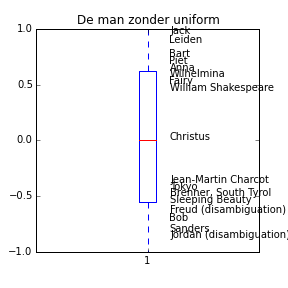

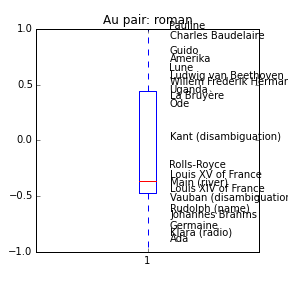

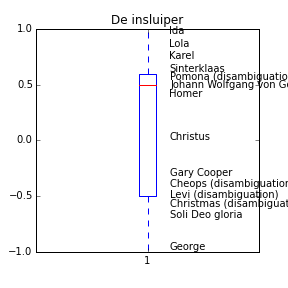

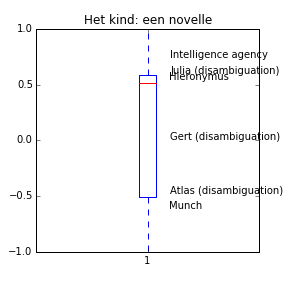

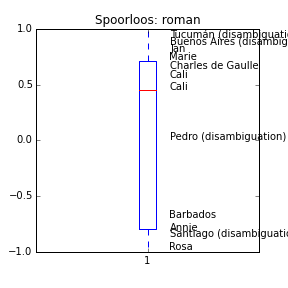

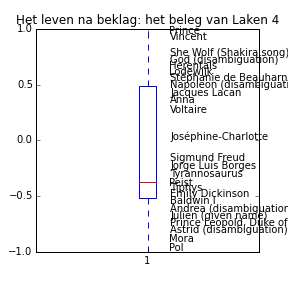

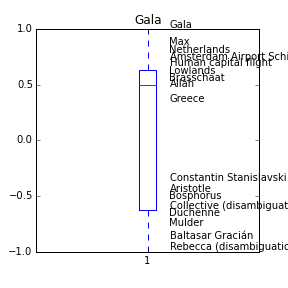

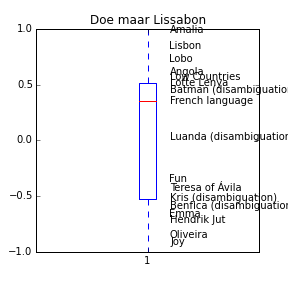

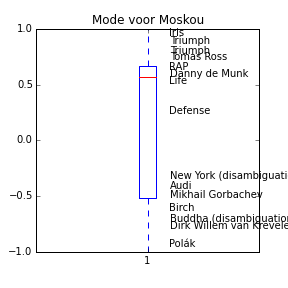

In [116]:
for bookTitle in allSummaries:
    plt.figure(figsize=(4,4))
    candlePerBook(bookTitle, allSummaries[bookTitle])
    plt.savefig('images/' + bookTitle + '_candle.png')
    plt.close()
    display(Image(filename='images/' + bookTitle + '_candle.png'))